In [126]:
import pandas as pd 
import numpy as np
import os
# Scikit-Learn
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import  OneHotEncoder, PowerTransformer
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import train_test_split 
from sklearn import metrics
# Xgboost
from xgboost import XGBRegressor

import warnings 
warnings.filterwarnings('ignore')

In [72]:
DATA_DIR_iterim = '../data/iterim/'
df = pd.read_csv(os.path.join(DATA_DIR_iterim, 'bikes-03-no_outliers.csv'))
df.columns

Index(['brand_name', 'model_name', 'motor_size', 'years', 'kms_driven',
       'mileage', 'owner', 'power', 'price'],
      dtype='object')

In [73]:
# Split dataset in features and target

X = df.drop(['price'], axis=1)
y = df['price']

In [85]:
# Split in train and test data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25) 

In [105]:
cat_features = ['brand_name', 'model_name']
cat_transformer = OneHotEncoder(handle_unknown='ignore')

num_features = ['motor_size', 'years', 'kms_driven',
                'mileage', 'power']
num_transformer = PowerTransformer()

column_transform = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_features),
        ("cat", cat_transformer, cat_features)
    ]
)

In [106]:
pipe = Pipeline([("col_trans", column_transform),
                 ("regressor", RandomForestRegressor())])

grid_param = [
                {
                    "regressor": [GradientBoostingRegressor()]                 
                },
                 {
                     "regressor": [Lasso()],
                 },
                 {
                     "regressor": [Ridge()],
                 },
                {
                    "regressor": [RandomForestRegressor()]
                },
                {
                    "regressor": [XGBRegressor()]
                }
]

gridsearch = GridSearchCV(pipe, grid_param, cv=6, verbose=0, n_jobs=-1)
best_model = gridsearch.fit(X_train, y_train) 

In [107]:
best_model.best_estimator_

Pipeline(steps=[('col_trans',
                 ColumnTransformer(transformers=[('num', PowerTransformer(),
                                                  ['motor_size', 'years',
                                                   'kms_driven', 'mileage',
                                                   'power']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['brand_name',
                                                   'model_name'])])),
                ('regressor', GradientBoostingRegressor())])

In [119]:
best_model.score(X_test, y_test)


0.918046834891031

In [122]:
import matplotlib.pyplot as plt
import seaborn as sns

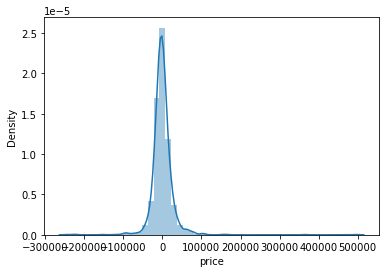

In [124]:
y_pred = best_model.predict(X_test)
sns.distplot(y_test - y_pred)
plt.show()

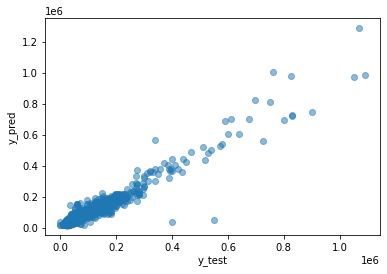

In [125]:
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

In [138]:
# Metrics
# Price is in Rupias, 1 Ru = 0.013 USD

print(f"MAE :  {metrics.mean_absolute_error(y_test, y_pred)} Ru = {metrics.mean_absolute_error(y_test, y_pred) * 0.013} USD")
print(f"MSE :  {metrics.mean_squared_error(y_test, y_pred)} Ru = {metrics.mean_squared_error(y_test, y_pred) * 0.013} USD")
print(f"RMSE: {np.sqrt(metrics.mean_squared_error(y_test, y_pred))} Ru = {np.sqrt(metrics.mean_squared_error(y_test, y_pred))* 0.013} USD")

MAE :  15678.105561608345 Ru = 203.81537230090848 USD
MSE :  787578572.7186682 Ru = 10238521.445342686 USD
RMSE: 28063.830328710803 Ru = 364.8297942732404 USD


## Hyperparameter Tuning

In [140]:
from sklearn.model_selection import RandomizedSearchCV

In [165]:
# Hyperparameters 

learning_rate = [0.1, 0.2, 0.3]
n_estimators = [int(x) for x in np.linspace(start=100, stop=1200, num=12)]
max_depth = [int(x) for x in np.linspace(3, 30, num=10)]
min_samples_split  = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10]

In [167]:
# Grid for Random search
random_grid = {
               'regressor__learning_rate': learning_rate,
               'regressor__n_estimators': n_estimators,
               'regressor__max_depth': max_depth,
               'regressor__min_samples_split': min_samples_split,
               'regressor__min_samples_leaf': min_samples_leaf
                }

In [169]:
gbr_random = RandomizedSearchCV(estimator=best_model.best_estimator_, param_distributions=random_grid, 
                                scoring='neg_mean_squared_error', n_iter=10, cv=5, n_jobs=-1, verbose=2)

In [170]:
gbr_random.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('col_trans',
                                              ColumnTransformer(transformers=[('num',
                                                                               PowerTransformer(),
                                                                               ['motor_size',
                                                                                'years',
                                                                                'kms_driven',
                                                                                'mileage',
                                                                                'power']),
                                                                              ('cat',
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                   

In [171]:
gbr_random.best_params_

{'regressor__n_estimators': 1200,
 'regressor__min_samples_split': 15,
 'regressor__min_samples_leaf': 5,
 'regressor__max_depth': 3,
 'regressor__learning_rate': 0.1}

In [172]:
predictions = gbr_random.predict(X_test)

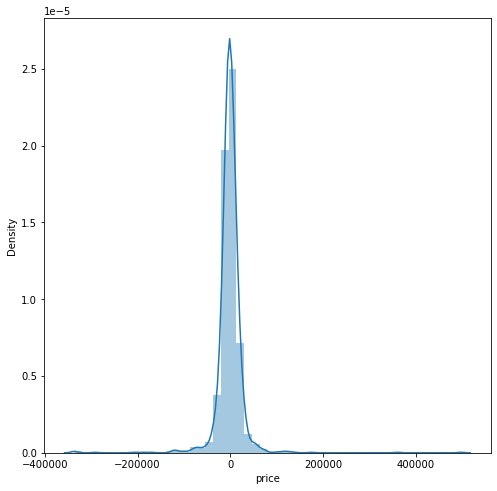

In [173]:
plt.figure(figsize=(8,8))
sns.distplot(y_test - predictions)
plt.show()

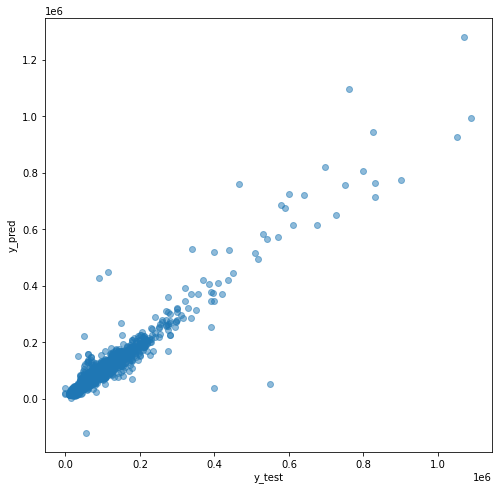

In [174]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test, predictions, alpha=0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

In [175]:
# Metrics

print(f"MAE :  {metrics.mean_absolute_error(y_test, predictions)} Ru = {metrics.mean_absolute_error(y_test, predictions) * 0.013} USD")
print(f"MSE :  {metrics.mean_squared_error(y_test, predictions)} Ru = {metrics.mean_squared_error(y_test, predictions) * 0.013} USD")
print(f"RMSE: {np.sqrt(metrics.mean_squared_error(y_test, predictions))} Ru = {np.sqrt(metrics.mean_squared_error(y_test, predictions))* 0.013} USD")

MAE :  14593.40068301642 Ru = 189.71420887921346 USD
MSE :  927252544.4339836 Ru = 12054283.077641785 USD
RMSE: 30450.821736596594 Ru = 395.8606825757557 USD


In [176]:
metrics.r2_score(y_test, predictions)

0.903512762403638

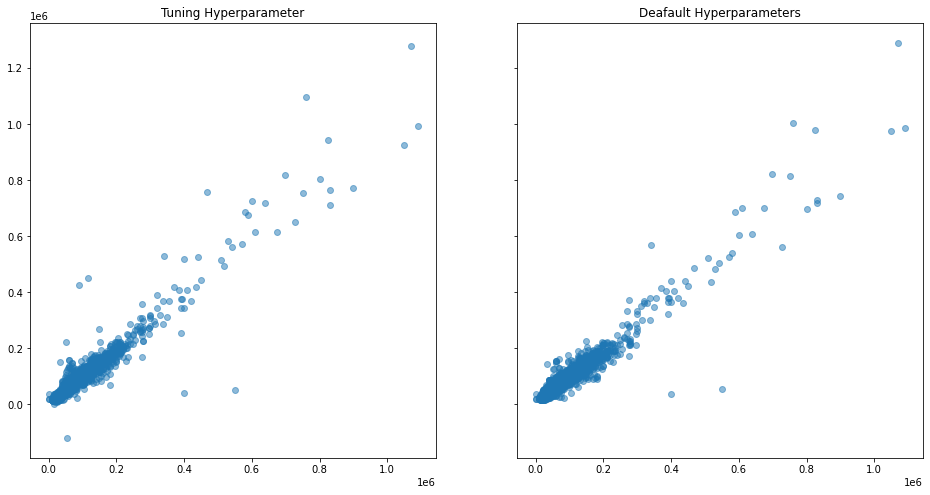

In [189]:
fig, axs = plt.subplots(1, 2, figsize=(16,8), sharey=True)
axs[0].scatter(y_test, predictions, alpha=0.5)
axs[0].set_title("Tuning Hyperparameter")
axs[1].scatter(y_test, y_pred, alpha=0.5)
axs[1].set_title("Deafault Hyperparameters")
plt.show()

In this case the default options was better as optimized hyperparams

## Save the model

In [177]:
import pickle

In [179]:
# open a file
file = open('../models/used_motorcycles_prices.pkl', 'wb')

# dump information
pickle.dump(best_model, file)